# ニューラルネットワーク

## MNISTデータセットの読み込み
### バイナリファイルから

In [2]:
import os
import struct
import numpy as np

def load_mnist(path, kind = 'train'):
    # 引数に指定したパスを結合
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
    
    # ファイルを読み込む：
    # 引数にファイル，モードを指定（rbは読み込みのバイナリモード）
    with open(labels_path, 'rb') as lbpath:
        # バイナリを文字列に変換
        magic, n = struct.unpack('>II', lbpath.read(8))
        # ファイルからラベルを読み込み配列を構築
        labels = np.fromfile(lbpath, dtype = np.uint8)
        
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        # 画像ピクセル情報の配列のサイズを変更（行数：ラベルのサイズ，　列数：特徴量の個数）
        images = np.fromfile(imgpath, dtype = np.uint8).reshape(len(labels), 784)
    
    return images, labels

In [3]:
X_train, y_train = load_mnist('mnist', kind = 'train')
print('Rows: %d , columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('mnist', kind = 't10k')
print('Rows: %d , columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 60000 , columns: 784
Rows: 10000 , columns: 784


### CSVから

In [2]:
import numpy as np

X_train = np.genfromtxt('mnist/train_img.csv', dtype = int, delimiter = ',')
y_train = np.genfromtxt('mnist/train_labels.csv', dtype = int, delimiter = ',')
X_test = np.genfromtxt('mnist/test_img.csv', dtype = int, delimiter = ',')
y_test = np.genfromtxt('mnist/test_labels.csv', dtype = int, delimiter = ',')

In [3]:
print('Rows: %d , columns: %d' % (X_train.shape[0], X_train.shape[1]))
print('Rows: %d , columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 60000 , columns: 784
Rows: 10000 , columns: 784


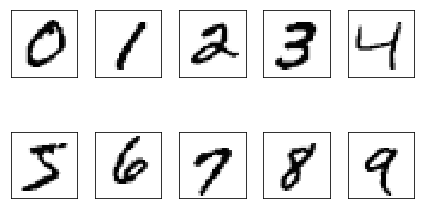

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows = 2, ncols = 5, sharex = True, sharey = True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap = 'Greys', interpolation = 'nearest')
    
ax[0].set_xticks([])
ax[0].set_yticks([])

plt.tight_layout()
plt.show()

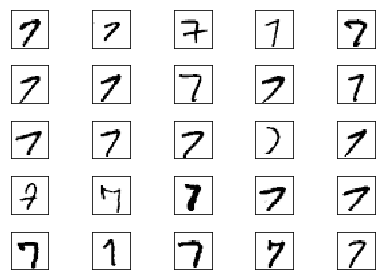

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows = 5, ncols = 5, sharex = True, sharey = True)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap = 'Greys', interpolation = 'nearest')
    
ax[0].set_xticks([])
ax[0].set_yticks([])

plt.tight_layout()
plt.show()

- ## トレーニングデータセットの学習

In [6]:
import mlp
import importlib
importlib.reload(mlp)

nn = mlp.NeuralNetMLP(n_output = 10,
                     n_features = X_train.shape[1],
                     n_hidden = 50,
                     l2 = 0.1,
                     l1 = 0.0,
                     epochs = 1000,
                     eta = 0.001,
                     alpha = 0.001,
                     decrease_const = 0.00001,
                     shuffle = True,
                     minibatches = 50,
                     random_state = 1)

In [7]:
nn.fit(X_train, y_train, print_progress = True)

Epoch: 1000/1000

- ## コストの推移

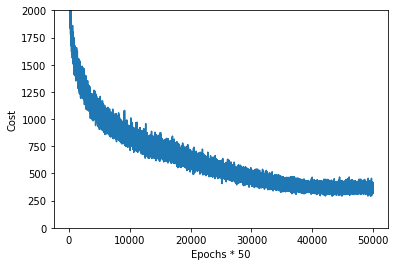

In [8]:
plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylim([0, 2000])
plt.ylabel('Cost')
plt.xlabel('Epochs * 50')
plt.show()

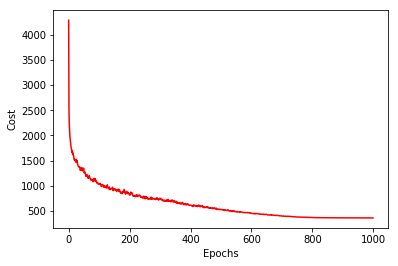

In [9]:
batches = np.array_split(range(len(nn.cost_)), 1000)
cost_ary = np.array(nn.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]
plt.plot(range(len(cost_avgs)), cost_avgs, color = 'red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

In [10]:
y_train_pred = nn.predict(X_train)
acc = np.sum(y_train == y_train_pred, axis = 0) / X_train.shape[0]
print('Training accuracy: %.2f%%' % (acc * 100))

Training accuracy: 97.67%


In [11]:
y_test_pred = nn.predict(X_test)
acc = np.sum(y_test == y_test_pred, axis = 0) / X_test.shape[0]
print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 96.01%


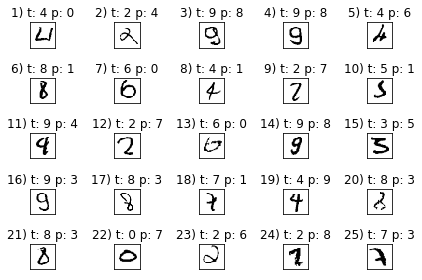

In [12]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]
fig, ax = plt.subplots(nrows = 5, ncols = 5, sharex = True, sharey = True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap = 'Greys', interpolation = 'nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i + 1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

- ## 勾配チェックを使ったニューラルネットワークのデバッグ

In [13]:
import mlpgc
import importlib
importlib.reload(mlpgc)

nn_check = mlpgc.MLPGradientCheck(n_output = 10,
                     n_features = X_train.shape[1],
                     n_hidden = 10,
                     l2 = 0.0,
                     l1 = 0.0,
                     epochs = 10,
                     eta = 0.001,
                     alpha = 0.0,
                     decrease_const = 0.0,
                     minibatches = 1,
                     random_state = 1)

In [14]:
nn_check.fit(X_train[:5], y_train[:5], print_progress = False)

Ok: 2.632241250645946e-10
Ok: 2.940560465957112e-10
Ok: 2.944171550323622e-10
Ok: 2.977466065690906e-10
Ok: 2.666763308631167e-10
Ok: 2.9108793620279266e-10
Ok: 2.935664208600547e-10
Ok: 2.570858517297691e-10
Ok: 3.3653653507852517e-10
Ok: 3.088968990506981e-10
